# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [1]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [2]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

Train–Validation Split(70–30)

In [3]:

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER
)


Initialize MLP Parameters

In [4]:
def init_layer(in_dim, out_dim):
    W = torch.randn(in_dim, out_dim) * 0.1
    b = torch.zeros(out_dim)

    W.requires_grad_()
    b.requires_grad_()

    return {"W": W, "b": b}

layers = [
    init_layer(2, 16),
    init_layer(16, 16),
    init_layer(16, 16),
    init_layer(16, 1)
]


Forward Pass

In [5]:
def relu(x):
    return torch.clamp(x, min=0)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def forward(X, layers):
    a = X
    for i, layer in enumerate(layers):
        z = torch.matmul(a, layer["W"]) + layer["b"]
        if i < len(layers) - 1:
            a = relu(z)
        else:
            a = sigmoid(z)
    return a


Binary Cross Entropy

In [6]:
def binary_cross_entropy(y_pred, y_true):
    eps = 1e-7
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    return -(y_true * torch.log(y_pred) +
             (1 - y_true) * torch.log(1 - y_pred)).mean()


Training Loop (Gradient Descent)

In [7]:
learning_rate = 0.05
epochs = 5000

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # Forward pass
    y_pred = forward(X_train, layers)
    loss = binary_cross_entropy(y_pred, y_train)

    # Backward pass
    loss.backward()

    # SGD update
    with torch.no_grad():
        for layer in layers:
            layer["W"] -= learning_rate * layer["W"].grad
            layer["b"] -= learning_rate * layer["b"].grad
            layer["W"].grad.zero_()
            layer["b"].grad.zero_()

    # Compute metrics
    with torch.no_grad():
        train_acc = ((y_pred > 0.5) == y_train).float().mean().item()
        val_pred = forward(X_val, layers)
        val_loss = binary_cross_entropy(val_pred, y_val).item()
        val_acc = ((val_pred > 0.5) == y_val).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}")


Epoch 0: Loss=0.6934
Epoch 50: Loss=0.6824
Epoch 100: Loss=0.6793
Epoch 150: Loss=0.6782
Epoch 200: Loss=0.6777
Epoch 250: Loss=0.6773
Epoch 300: Loss=0.6769
Epoch 350: Loss=0.6764
Epoch 400: Loss=0.6758
Epoch 450: Loss=0.6751
Epoch 500: Loss=0.6743
Epoch 550: Loss=0.6731
Epoch 600: Loss=0.6717
Epoch 650: Loss=0.6699
Epoch 700: Loss=0.6676
Epoch 750: Loss=0.6646
Epoch 800: Loss=0.6609
Epoch 850: Loss=0.6560
Epoch 900: Loss=0.6493
Epoch 950: Loss=0.6380
Epoch 1000: Loss=0.6203
Epoch 1050: Loss=0.5993
Epoch 1100: Loss=0.5774
Epoch 1150: Loss=0.5566
Epoch 1200: Loss=0.5383
Epoch 1250: Loss=0.5224
Epoch 1300: Loss=0.5085
Epoch 1350: Loss=0.4958
Epoch 1400: Loss=0.4851
Epoch 1450: Loss=0.4767
Epoch 1500: Loss=0.4699
Epoch 1550: Loss=0.4645
Epoch 1600: Loss=0.4605
Epoch 1650: Loss=0.4574
Epoch 1700: Loss=0.4549
Epoch 1750: Loss=0.4529
Epoch 1800: Loss=0.4512
Epoch 1850: Loss=0.4496
Epoch 1900: Loss=0.4483
Epoch 1950: Loss=0.4470
Epoch 2000: Loss=0.4456
Epoch 2050: Loss=0.4442
Epoch 2100: Los

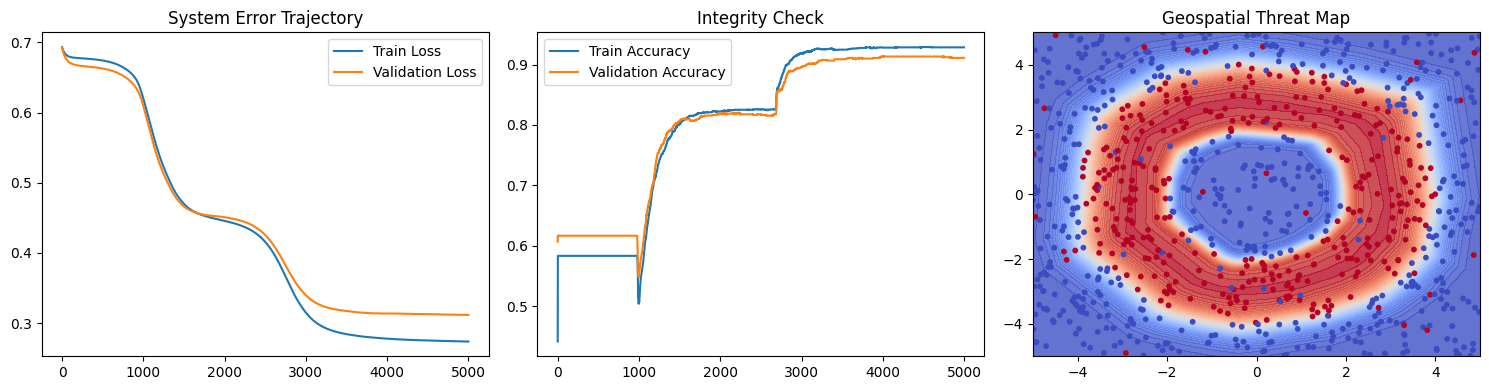

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("System Error Trajectory")
plt.legend()
plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Integrity Check")
plt.legend()
xx, yy = torch.meshgrid(
    torch.linspace(-5, 5, 300),
    torch.linspace(-5, 5, 300),
    indexing="ij"
)

grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    zz = forward(grid, layers).reshape(xx.shape)

plt.subplot(1,3,3)
plt.contourf(xx, yy, zz, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val.squeeze(),
            cmap="coolwarm", s=10)
plt.title("Geospatial Threat Map")

plt.tight_layout()
plt.show()
